In [15]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib as mpl
from influxdb_client import InfluxDBClient
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import RobustScaler, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import joblib

In [16]:
# 1. 폰트 설정
font_path = "/System/Library/Fonts/Supplemental/AppleGothic.ttf"
fontprop = fm.FontProperties(fname=font_path)
font_name = fontprop.get_name()
mpl.rcParams['font.family'] = font_name
mpl.rcParams['axes.unicode_minus'] = False
sns.set_style("whitegrid")
plt.rcParams['font.family'] = font_name

In [ ]:
# 2. InfluxDB 연결 함수
def get_influx_client():
    INFLUX_URL   = "https://influx.aiot2.live"
    INFLUX_TOKEN = "RmaabELI9VpYPRu4nt_xBZX5l3Gv5lx8XnR4mVZnqep4Ya3eYrfpLUk4Y4dYE4J0mlcFHFPLUCKh8a4jq_lMNw=="
    INFLUX_ORG   = "aiot2-team2-coffee"
    INFLUX_BUCKET= "coffee-mqtt"
    client = InfluxDBClient(url=INFLUX_URL, token=INFLUX_TOKEN, org=INFLUX_ORG)
    return client, INFLUX_BUCKET

sensor_types = ["temperature", "humidity", "co2"]
target_locations = ["8인 책상", "왼쪽 뒤", "안쪽벽 중앙", "보드"]

client, INFLUX_BUCKET = get_influx_client()
read_api = client.query_api()

sensor_filter = ' or '.join([f'r["type"] == "{t}"' for t in sensor_types])
location_filter = ' or '.join([f'r["location"] == "{loc}"' for loc in target_locations])

flux = f'''
from(bucket: "{INFLUX_BUCKET}")
  |> range(start: -7d)
  |> filter(fn: (r) => r["_measurement"] == "sensor")
  |> filter(fn: (r) => r["_field"] == "value")
  |> filter(fn: (r) => {sensor_filter})
  |> filter(fn: (r) => {location_filter})
  |> aggregateWindow(every: 5m, fn: mean, createEmpty: false)
  |> yield(name: "mean")
'''


In [ ]:
df = read_api.query_data_frame(flux)
df = pd.concat(df) if isinstance(df, list) else df

# 정리 및 피벗
df = df.reset_index().rename(columns={"_time": "time"}).set_index("time")
pivot_df = df.pivot_table(index=['time', 'location'], columns='type', values='_value').reset_index()
pivot_df = pivot_df.sort_values(by='time')

# 면적 매핑 및 파생 변수 추가
location_area_map = {"8인 책상": 64.65, "왼쪽 뒤": 109.21, "안쪽벽 중앙": 25.13, "보드": 31.59}
pivot_df['area'] = pivot_df['location'].map(location_area_map)
pivot_df['co2_per_area'] = pivot_df['co2'] / pivot_df['area']

# 결측치 처리
imputer = IterativeImputer(random_state=42)
pivot_df[['temperature', 'humidity', 'co2']] = imputer.fit_transform(pivot_df[['temperature', 'humidity', 'co2']])


/opt/homebrew/anaconda3/lib/python3.12/site-packages/influxdb_client/client/warnings.py:31: MissingPivotFunction: The query doesn't contains the pivot() function.

The result will not be shaped to optimal processing by pandas.DataFrame. Use the pivot() function by:

    
from(bucket: "coffee-mqtt")
  |> range(start: -7d)
  |> filter(fn: (r) => r["_measurement"] == "sensor")
  |> filter(fn: (r) => r["_field"] == "value")
  |> filter(fn: (r) => r["type"] == "temperature" or r["type"] == "humidity" or r["type"] == "co2")
  |> filter(fn: (r) => r["location"] == "8인 책상" or r["location"] == "왼쪽 뒤" or r["location"] == "안쪽벽 중앙" or r["location"] == "보드")
  |> aggregateWindow(every: 5m, fn: mean, createEmpty: false)
  |> yield(name: "mean")
 |> pivot(rowKey:["_time"], columnKey: ["_field"], valueColumn: "_value")

You can disable this warning by:
    import warnings
    from influxdb_client.client.warnings import MissingPivotFunction

    warnings.simplefilter("ignore", MissingPivotFunction)

Fo

18300


In [25]:
# ⛅ CEI 계산 함수들
def temp_score(temp):
    if 22 <= temp <= 24: return 100
    elif 20 <= temp < 22 or 24 < temp <= 26: return 85
    elif 18 <= temp < 20 or 26 < temp <= 28: return 65
    else: return 40

def humidity_score(humi):
    if 40 <= humi <= 50: return 100
    elif 30 <= humi < 40 or 50 < humi <= 60: return 85
    elif 25 <= humi < 30 or 60 < humi <= 70: return 65
    else: return 40

def co2_score(co2):
    if co2 <= 800: return 100
    elif co2 <= 1000: return 85
    elif co2 <= 1200: return 65
    else: return max(40, 100 - np.log1p(co2 - 800) * 10)

def compute_cei_v2(temp, humi, co2):
    t, h, c = temp_score(temp), humidity_score(humi), co2_score(co2)
    return 0.4 * t + 0.3 * h + 0.3 * c

def cei_to_label(cei):
    if cei >= 90: return "😊 최적 쾌적"
    elif cei >= 70: return "😐 보통 상태"
    elif cei >= 50: return "⚠️ 주의 필요"
    else: return "🥵 위험 구역"


In [26]:
# 🧠 CEI 점수 및 라벨 적용
pivot_df['CEI'] = pivot_df.apply(lambda x: compute_cei_v2(x['temperature'], x['humidity'], x['co2']), axis=1)
pivot_df['CEI_Label'] = pivot_df['CEI'].apply(cei_to_label)

# 결과 미리보기
print(pivot_df[['temperature', 'humidity', 'co2', 'CEI', 'CEI_Label']].head())


type  temperature  humidity        co2   CEI CEI_Label
0           25.10    23.500  575.00000  76.0   😐 보통 상태
1           23.50    37.500  609.06465  95.5   😊 최적 쾌적
2           23.50    34.500  800.00000  95.5   😊 최적 쾌적
3           25.10    23.700  583.00000  76.0   😐 보통 상태
4           24.65    33.375  635.00000  89.5   😐 보통 상태


In [27]:
# 이동 평균 (시계열 기반 특성)
pivot_df['temp_ma3'] = pivot_df.groupby('location')['temperature'].transform(lambda x: x.rolling(3, min_periods=1).mean())
pivot_df['humi_ma3'] = pivot_df.groupby('location')['humidity'].transform(lambda x: x.rolling(3, min_periods=1).mean())
pivot_df['co2_ma3']  = pivot_df.groupby('location')['co2'].transform(lambda x: x.rolling(3, min_periods=1).mean())


In [28]:
pivot_df['hour'] = pd.to_datetime(pivot_df['time']).dt.hour
pivot_df['work_hour'] = pivot_df['hour'].apply(lambda h: 1 if 9 <= h <= 18 else 0)


In [29]:
feature_cols = ['temperature', 'humidity', 'co2',
                'temp_ma3', 'humi_ma3', 'co2_ma3',
                'co2_per_area', 'work_hour']



📊 Classification Report:
               precision    recall  f1-score   support

     😊 최적 쾌적       1.00      1.00      1.00       829
     😐 보통 상태       1.00      1.00      1.00       459

    accuracy                           1.00      1288
   macro avg       1.00      1.00      1.00      1288
weighted avg       1.00      1.00      1.00      1288



/opt/homebrew/anaconda3/lib/python3.12/site-packages/seaborn/utils.py:61: UserWarning: Glyph 128522 (\N{SMILING FACE WITH SMILING EYES}) missing from font(s) AppleGothic.
  fig.canvas.draw()
/opt/homebrew/anaconda3/lib/python3.12/site-packages/seaborn/utils.py:61: UserWarning: Glyph 128528 (\N{NEUTRAL FACE}) missing from font(s) AppleGothic.
  fig.canvas.draw()
/opt/homebrew/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128522 (\N{SMILING FACE WITH SMILING EYES}) missing from font(s) AppleGothic.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/homebrew/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128528 (\N{NEUTRAL FACE}) missing from font(s) AppleGothic.
  fig.canvas.print_figure(bytes_io, **kw)


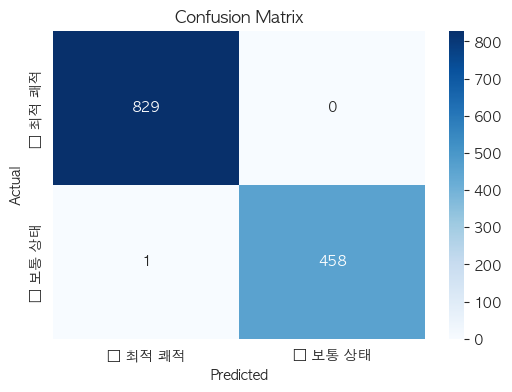

In [30]:
X = pivot_df[feature_cols]
y = pivot_df['CEI_Label']

# ✅ 3. 스케일링 + 라벨 인코딩
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X)

le = LabelEncoder()
y_encoded = le.fit_transform(y)

# ✅ 4. train-test 분리
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

# ✅ 5. 모델 학습 및 평가
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

# ✅ 6. 결과 리포트 출력
print("\n📊 Classification Report:\n", classification_report(y_test, y_pred, target_names=le.classes_))

# ✅ 7. 혼동 행렬 시각화
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_, cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()